In [1]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt



from hfnet.models import get_model
from hloc.utils.viz import plot_images, plot_keypoints
from hloc import feature_extractor_new
from hloc import match_feature_single
from hloc import localize_sfm_single
from hloc import extract_feature_single_masked
import jsonparser

In [2]:
## On GPU-2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'


In [3]:
path_to_image= Path("/home/Hierarchical-Localization/datasets/Trajectory3/Image_choosen/choosen.png")
path_to_mask = Path("/home/Hierarchical-Localization/datasets/Trajectory3/Image_added_scale_0.35_center_grey/iPhoSilWithWv3_1598592941_940-19930.png")
path_to_json = Path("/home/Hierarchical-Localization/datasets/Trajectory3/UsefulPoses")
path_to_model = Path("/home/Hierarchical-Localization/outputs/sfm_T5_skip_9_pba")
image_name_ori = "iPhoSilWithWv3_1598592941_940-19930.png"

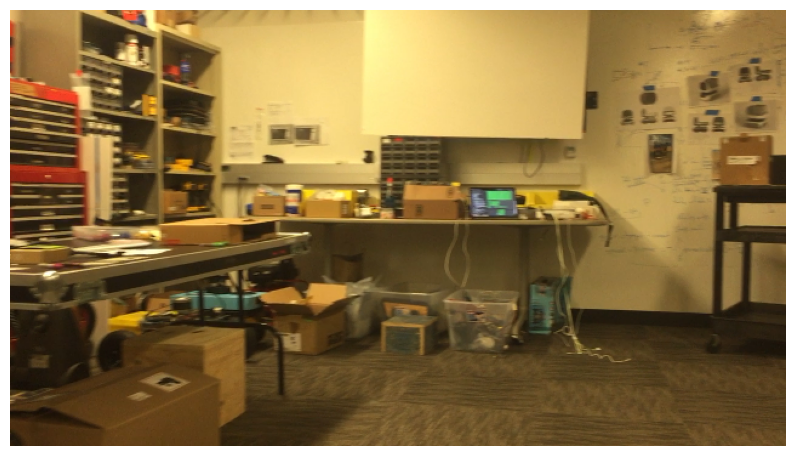

In [4]:
image_query = cv2.imread(str(path_to_image))
image_query = cv2.cvtColor(image_query, cv2.COLOR_BGR2RGB)
plot_images([image_query])

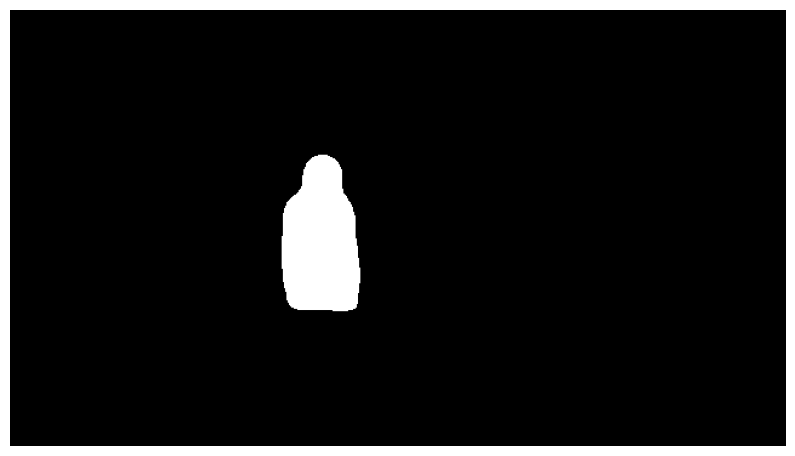

In [5]:
mask = cv2.imread(str(path_to_mask), cv2.IMREAD_GRAYSCALE)
plot_images([mask])

In [6]:
def global_descriptors_parser(path_to_model):
    file_name = 'global_features.h5'
    hfile = h5py.File(str(path_to_model/file_name), 'r')
    image_names = list(hfile.keys())
    desc = [hfile[i]['global_descriptor'].__array__() for i in image_names]
    desc = np.stack(desc, 0)
    return image_names, desc

In [7]:
global_image_names, global_matrix = global_descriptors_parser(path_to_model)
# If want to check the shapes
# len(global_image_names)
# np.shape(global_matrix)

In [8]:
## Send in a RGB image
def global_descriptor_query(config_global, image):
    checkpoint_path = Path(config_global["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config_global['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config_global['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        data = {"image": image}
        predictions = net.predict(data, keys=keys)
    return predictions['global_descriptor']

In [9]:
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")
config_global = {'checkpoint_path':checkpoint_path, 
                 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 
                 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         

In [10]:
# GlobalDescriptorQuery = global_descriptor_query(config_global, image_query)
# np.shape(GlobalDescriptorQuery)

In [11]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

In [12]:
def global_matches(path_to_model, config_global, image_query, number):
    image_names, global_matrix = global_descriptors_parser(path_to_model)
    GlobalDescriptorQuery = global_descriptor_query(config_global, image_query) 
    neighbours = compute_distance(GlobalDescriptorQuery, global_matrix)
    nearest_neighbours = np.argsort(neighbours)[:number]
    names_nearest = [image_names[i] for i in nearest_neighbours]
    return names_nearest, nearest_neighbours

In [13]:
names_nearest, nearest_neighbours =global_matches(path_to_model, config_global, image_query, 10)

W0219 01:24:48.346511 140402371569472 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0219 01:24:48.361671 140402371569472 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0219 01:24:48.362330 140402371569472 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0219 01:24:48.363117 140402371569472 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0219 01:24:48.366177 140402371569472 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [14]:
# print(names_nearest)
print(nearest_neighbours)

In [15]:
feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}

In [28]:
def local_descriptor_and_matches(image, path_to_model, feature_conf_superpoint, matcher_conf, names_nearest):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    query_stuff = feature_extractor_new.main(feature_conf_superpoint, image_gray)
    plot_images([image])
    plot_keypoints([query_stuff["keypoints"]], ps =8)
    feature_file = path_to_model/"features_superpoint.h5"
    matches_dict = match_feature_single.main(matcher_conf, query_stuff, names_nearest, feature_file)
    return matches_dict, query_stuff

In [29]:
def local_descriptor_and_matches_mask(image, path_to_model, feature_conf_superpoint, matcher_conf, names_nearest, mask):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    query_stuff = extract_feature_single_masked.main(feature_conf_superpoint, image_gray, mask)
    plot_images([image])
    plot_keypoints([query_stuff["keypoints"]], ps =8)
    feature_file = path_to_model/"features_superpoint.h5"
    matches_dict = match_feature_single.main(matcher_conf, query_stuff, names_nearest, feature_file)
    return matches_dict, query_stuff

I0219 01:24:52.774969 140402371569472 feature_extractor_new.py:63] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}


Loaded SuperPoint model


I0219 01:24:56.211442 140402371569472 feature_extractor_new.py:93] Finished exporting features.
I0219 01:24:56.248704 140402371569472 match_feature_single.py:48] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
 30%|███       | 3/10 [00:00<00:00, 20.99it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 10/10 [00:00<00:00, 20.69it/s]
I0219 01:24:56.933069 140402371569472 match_feature_single.py:105] Finished exporting matches.


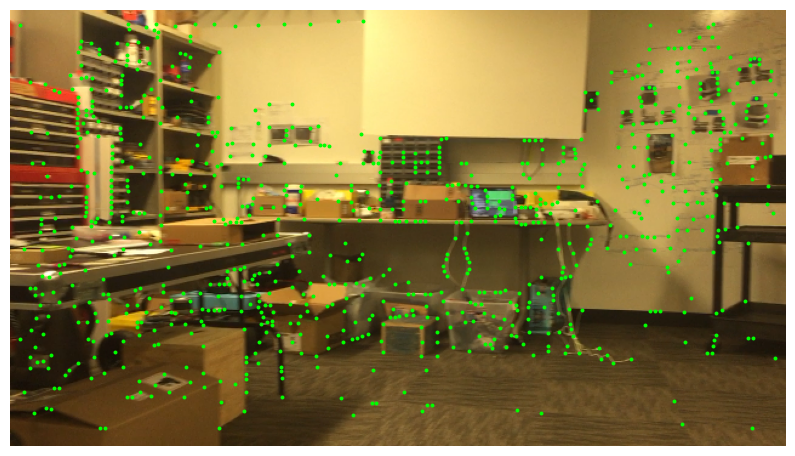

In [17]:
matches_dict,query_stuff = local_descriptor_and_matches(image_query, path_to_model, feature_conf_superpoint, matcher_conf,names_nearest)

In [18]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])
def colmap_to_global(_tvec, _qvec):
    return -np.matmul(qvec2rotmat(_qvec).transpose(), _tvec)

In [19]:
def localize(matches_dict, model, query_stuff, names_nearest):
    query_stuff["params"] = ("SIMPLE_RADIAL", 640, 480, (658.503, 320, 180, 0.0565491))
    pose = localize_sfm_single.main(model, query_stuff, names_nearest, matches_dict)
    pose_global = colmap_to_global(pose[1], pose[0])
    return pose_global

In [20]:
model = path_to_model/"sfm_superpoint+superglue"/"geo_registered_model"
tvec_sfm = localize(matches_dict, model, query_stuff, names_nearest )

I0219 01:24:57.240439 140402371569472 localize_sfm_single.py:76] Reading 3D model...
I0219 01:24:59.434835 140402371569472 localize_sfm_single.py:83] Starting localization...


In [21]:
def error(tvec, CtG):
    return np.linalg.norm(tvec-CtG)

In [22]:
names_trans_rot = jsonparser.parser(str(path_to_json))

In [23]:
tvec_ori = names_trans_rot[image_name_ori]["tvec"]

In [24]:
err = error(tvec_ori, tvec_sfm)

In [25]:
print(err)

0.0583609408747518


I0219 01:24:59.659568 140402371569472 extract_feature_single_masked.py:74] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}
I0219 01:24:59.697385 140402371569472 extract_feature_single_masked.py:105] Finished exporting features.
I0219 01:24:59.745113 140402371569472 match_feature_single.py:48] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperPoint model


 30%|███       | 3/10 [00:00<00:00, 21.67it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 10/10 [00:00<00:00, 21.04it/s]
I0219 01:25:00.455542 140402371569472 match_feature_single.py:105] Finished exporting matches.


({'query_iPhoSilWithWv5_1598600950_828-29314.png': {'scores': array([9.8047e-01, 9.8096e-01, 5.0098e-01, 9.8145e-01, 9.8193e-01,
          8.9844e-01, 9.7754e-01, 9.7412e-01, 4.3018e-01, 9.4922e-01,
          9.6436e-01, 9.3604e-01, 9.8096e-01, 9.7314e-01, 9.5898e-01,
          0.0000e+00, 8.5693e-01, 0.0000e+00, 9.8047e-01, 9.7852e-01,
          9.8145e-01, 9.7949e-01, 0.0000e+00, 9.5361e-01, 9.6973e-01,
          9.8145e-01, 9.7314e-01, 9.7949e-01, 9.7070e-01, 0.0000e+00,
          9.7217e-01, 8.3350e-01, 9.0674e-01, 9.7949e-01, 9.7949e-01,
          9.7852e-01, 9.5947e-01, 9.5166e-01, 9.7803e-01, 9.7754e-01,
          9.7803e-01, 9.7510e-01, 9.5898e-01, 9.4922e-01, 0.0000e+00,
          0.0000e+00, 9.7461e-01, 7.5098e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 6.4453e-02, 9.7705e-01, 9.7559e-01,
          9.7852e-01, 9.7803e-01, 9.7363e-01, 9.1016e-01, 0.0000e+00,
          9.6387e-01, 0.0000e+00, 9.4922e-01, 9.7852e-01, 0.0000e+00,
          9.8096e-01, 9.7168e-0

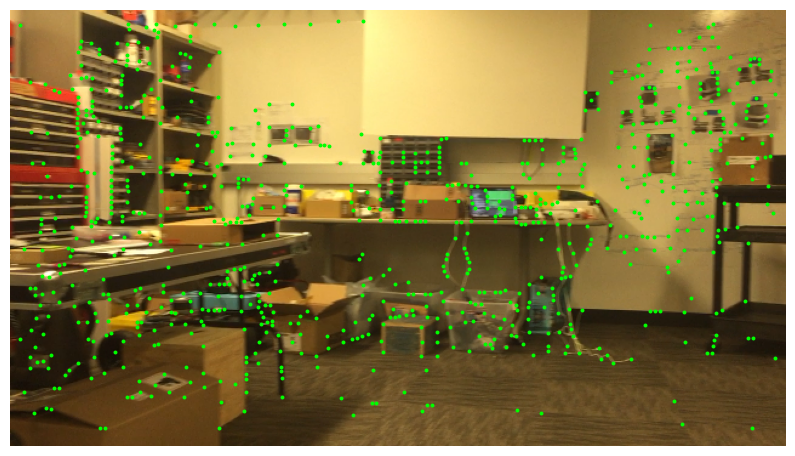

In [27]:
local_descriptor_and_matches_mask(image_query, path_to_model, feature_conf_superpoint, matcher_conf,names_nearest, mask)